# The ABM

# Table of Contents
1. [Libraries and Import Data](#data)<br>
2. [The Agents](#age)<br>
3. [The Model](#model)<br>
4. [Saving Files](#save)<br>


# 1. Libraries and Import Data <a name="data"></a>

In [1]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import networkx as nx
import random
from tqdm.notebook import tqdm
import time
from numpy.random import multinomial
from datetime import datetime
import pickle
from collections import defaultdict
import matplotlib.patches as mpatches
import matplotlib

In [3]:
am_counts_df = pd.read_csv('data/am_counts_df.csv')
nil_age = pd.read_csv("data/Distribuzione Età NIL.csv", sep = ";", encoding = "ISO-8859-1")
fermate_nils = pd.read_csv("data/fermate_NILs.csv")
time_series = pd.read_csv("data/settimanale.csv")
activities = pd.read_csv("data/trasporti_finalizzati.csv")
orari = pd.read_csv("data/orari.csv")
fermate = pd.read_csv("data/fermate.csv")

In [4]:
# importing the network and foot edges
G = nx.read_gpickle("data/G.gpickle")

file = open('data/foot', 'rb')
foot = pickle.load(file)
file.close()

file = open('data/d_active_edges', 'rb')
d_active_edges = pickle.load(file)
file.close()

file = open('data/coords.pkl', 'rb')
coords = pickle.load(file)
file.close()

file = open('data/percorsi', 'rb')
percorsi = pickle.load(file)
file.close()

# 2. The Agents<a name="age"></a>

<div class="alert alert-success" >
In this section we use ISTAT data in order to create the probability distributions used in the generation of the agents. In particular, they are used to draw:
    
- age group;<br>
- NIL of residence;<br>
- activities carried out;<br>
- departure times;<br>
- destinations.<br>
    
We create a class Agent in which we specify all the attributes necessary for the simulation. </div>    
    

### Generating the DataFrames

In [5]:
# Homologating age groups across the nil_age and the other DFs
# remove individuals younger than 14
nil_age = nil_age.loc[nil_age["Età (classi funzionali)"].isin(['14-18 anni',
       '19-24 anni', '25-34 anni', '35-44 anni', '45-54 anni',
       '55-64 anni', '65-74 anni', '75-84 anni', '85 anni e più'])]

# create "wider" classes
def age_groups(row):
    age_group = row["Età (classi funzionali)"]
    if age_group in ['14-18 anni', '19-24 anni']:
        return "15-24 anni"
    elif age_group in ['25-34 anni', '35-44 anni']:
        return "25-44 anni"
    elif age_group in ['45-54 anni', '55-64 anni']:
        return '45-64 anni'
    else:
        return '65 anni e più'
    
nil_age["Età (classi funzionali)"] = nil_age.apply(lambda x: age_groups(x), axis = 1)

# sum residents for cells relative to same age group and nil
nil_age = nil_age.groupby(by = ["Età (classi funzionali)", "NIL (Nuclei di Identità Locale)"]).sum().reset_index()

In [6]:
# extract NIL number...
nil_age["num"]=nil_age["NIL (Nuclei di Identità Locale)"].apply(lambda x: x[-3:-1] if x[-3] != "(" else  x[-2:-1]).astype("int")
# (missing 8 - Parco Sempione: 2 people 2019, no one currently registered living there)

In [7]:
# ... and remove number from NIL name
nil_age["NIL (Nuclei di Identità Locale)"]=nil_age["NIL (Nuclei di Identità Locale)"].apply(lambda x: x[:-4].upper() if x[-4] != "(" else  x[:-5].upper())

In [8]:
# create the Age distibution
age_distro = nil_age.groupby(by = "Età (classi funzionali)").sum()
age_distro = age_distro.reset_index().sort_values(["num"])
pop_mi = age_distro.Residenti.sum(axis = 0) # total population in Milan
#add a proportion column
age_distro["Proportion"] = age_distro["Residenti"].apply(lambda x: x/pop_mi)
print("Tot number of Age Groups:", age_distro["Età (classi funzionali)"].nunique())
age_distro.head()

Tot number of Age Groups: 4


,Età (classi funzionali),Residenti,num,Proportion
0,15-24 anni,137295,3908,0.111692
1,25-44 anni,367162,3908,0.298694
2,45-64 anni,412991,3908,0.335977
3,65 anni e più,311777,3908,0.253637


In [9]:
def nil_distro_age(row):
    """
    For each age group compute the proportion of different NILs.
    """
    tot = nil_age[nil_age["Età (classi funzionali)"] == row["Età (classi funzionali)"]].Residenti.sum()
    return row.Residenti / tot

nil_age["nil_distro"] = nil_age.apply(lambda x: nil_distro_age(x), axis = 1)
nil_age.groupby(by = "Età (classi funzionali)").sum() # check they sum up to 1

,Residenti,num,nil_distro
Età (classi funzionali),,,
15-24 anni,137295,3908,1.0
25-44 anni,367162,3908,1.0
45-64 anni,412991,3908,1.0
65 anni e più,311777,3908,1.0


In [10]:
# importing the df with time series of proportion of idivididuals carrying out specific activities by age class
time_series = time_series.rename(columns = {"Classe di età": "Age", "Tipo attività": "Activity"})
time_series["Time"] =pd.to_datetime(time_series["Periodo temporale di riferimento"].apply(lambda x: x[25:30]),format='%H:%M').dt.strftime('%H:%M:%S')
time_series = time_series.drop(columns = ["Periodo temporale di riferimento"])
time_series.head()

,Age,Activity,Value,Time
0,15-24 anni,"dormire, mangiare e altra cura della persona",73.0,00:00:00
1,15-24 anni,"dormire, mangiare e altra cura della persona",75.8,00:10:00
2,15-24 anni,"dormire, mangiare e altra cura della persona",77.4,00:20:00
3,15-24 anni,"dormire, mangiare e altra cura della persona",80.6,00:30:00
4,15-24 anni,"dormire, mangiare e altra cura della persona",82.1,00:40:00


In [11]:
time_series["datetime"] = time_series.Time.apply(lambda x: datetime.strptime(x, "%H:%M:%S").time())

In [12]:
# extract moving actvity and drop it from time_series
ts_moving = time_series[time_series["Activity"] == "spostamenti finalizzati"]
time_series = time_series[time_series["Activity"] != "spostamenti finalizzati"]
ts_moving.head()

,Age,Activity,Value,Time,datetime
573,15-24 anni,spostamenti finalizzati,5.8,00:00:00,00:00:00
574,15-24 anni,spostamenti finalizzati,4.3,00:10:00,00:10:00
575,15-24 anni,spostamenti finalizzati,3.1,00:20:00,00:20:00
576,15-24 anni,spostamenti finalizzati,3.2,00:30:00,00:30:00
577,15-24 anni,spostamenti finalizzati,2.5,00:40:00,00:40:00


In [13]:
# assume people cannot start a new activity before 5:50:00 and after 23:20:00 (other than moving)
time_series = time_series[(time_series["datetime"] > datetime.strptime("05:50:00", "%H:%M:%S").time()) & 
                          (time_series["datetime"] < datetime.strptime("23:20:00", "%H:%M:%S").time())]

In [14]:
# assume people cannot set off for a new activity before 5:10:00 and after 22:40:00 (40 mins before ^ as this is the avg transit time on public transportation in Milan)
ts_moving = ts_moving[(ts_moving["datetime"] > datetime.strptime("05:10:00", "%H:%M:%S").time()) & 
                      (ts_moving["datetime"] < datetime.strptime("22:40:00", "%H:%M:%S").time())]

In [15]:
time_series.Activity.unique()

array(['dormire, mangiare e altra cura della persona',
       'istruzione e formazione', 'lavoro familiare', 'lavoro retribuito',
       'tempo libero'], dtype=object)

In [16]:
# for simplicity
sleep_eat = 'dormire, mangiare e altra cura della persona'
school = 'istruzione e formazione'
house = 'lavoro familiare'
work = 'lavoro retribuito'
move = 'spostamenti finalizzati'
free = 'tempo libero'

In [17]:
# for each time find its 40 minutes lag where I will have to draw from
time_series["Time_lag"] = (pd.to_datetime(time_series.Time) - pd.DateOffset(minutes=40)).dt.strftime('%H:%M:%S')

In [18]:
activities = activities[["Tipo attività", "Classe di età", "Value"]]
activities = activities.drop([3,8,10, 12,18,20,25,27]).reset_index(drop = True)
activities.head()

,Tipo attività,Classe di età,Value
0,spostamenti per tempo libero,25-44 anni,43.3
1,spostamenti da/per il lavoro,25-44 anni,50.5
2,spostamenti per lavoro familiare,25-44 anni,44.4
3,spostamenti per la cura della persona,25-44 anni,14.2
4,spostamenti per la cura della persona,15-24 anni,12.1


In [19]:
rescaled_ts = time_series.copy()

def rescale_activity(row, ts_moving):
    """
    Rescaling activities proportions time series by the proportion of people traveling 40 minutes prior (where 40 minutes is
    the average time of daily public transit usage in Milan).
    """
    age = row.Age 
    act = row.Activity
    time = row.Time_lag
    value = row.Value
    
    multiplier = ts_moving[(ts_moving["Age"]==age)&(ts_moving["Time"]==time)&(ts_moving["Activity"]==move)].Value.tolist()[0]
    
    return value*multiplier

rescaled_ts["Value"] = rescaled_ts.apply(lambda x: rescale_activity(x, ts_moving), axis = 1)

In [20]:
# sort by Time_lag which will be the object of the next "draws"
rescaled_ts = rescaled_ts.sort_values(["Age", "Activity", "Time_lag"]).reset_index(drop = True) 

In [21]:
def gen_act_density(row, totals):
    """
    Generate a density for each activity i.e. the probability of departing at each time specifically to carry out that
    activity.
    """
    value = row.Value
    age = row.Age
    act = row.Activity
    tot = totals[(totals["Age"] == age) & (totals["Activity"] == act)].Value.tolist()[0]
    
    return value / tot

totals = rescaled_ts.groupby(by = ["Age", "Activity"]).sum().reset_index()
rescaled_ts["Density"] = rescaled_ts.apply(lambda x: gen_act_density(x, totals), axis = 1)

In [22]:
# divide original df in different age groups
ts_15_24 = rescaled_ts[rescaled_ts["Age"] == "15-24 anni"]
ts_25_44 = rescaled_ts[rescaled_ts["Age"] == "25-44 anni"]
ts_45_64 = rescaled_ts[rescaled_ts["Age"] == "45-64 anni"]
ts_over_65 = rescaled_ts[rescaled_ts["Age"] == "65 anni e più"]
age_groups = [ts_15_24, ts_25_44, ts_45_64, ts_over_65]

In [23]:
def act (df, activity, time = "Time_lag", plot = False, density = False):
    """
    Specifying an age group dataframe and an activity, outputs the relative dataframe.
    If plot = True, instead outputs the time series plot.
    If density = True, plots the densities per time slot rather than the original proportion values. 
    """
    act = df[df["Activity"] == activity]
    if plot == True:
        if density == True:
            how = "Density"
        else:
            how = "Value"
        plt.figure(figsize=(8, 5), dpi=80)
        plt.plot(time, how, data = act)
        plt.xticks(ticks = range(0,108,6))
        plt.xticks(rotation = 45)
        plt.title(f"Activity {activity} for age group {df.Age.tolist()[0]} - {how}")
        return plt.show()
    return act

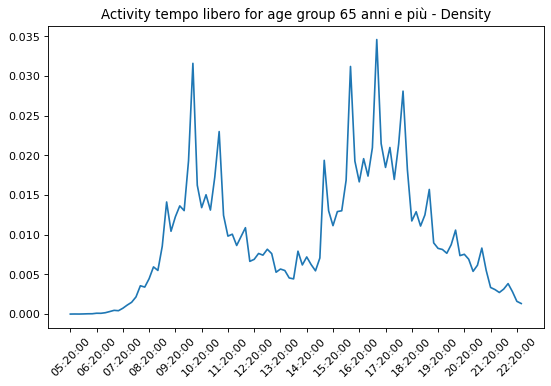

In [24]:
# example
act(ts_over_65, free, plot = True, density = True)

In [25]:
for i in activities["Classe di età"].unique():
    assert activities[activities["Classe di età"] == i]["Tipo attività"].nunique() == 5
print("All age classes have same activities.")

All age classes have same activities.


In [26]:
d_ages = {x:y for x,y in enumerate(nil_age["Età (classi funzionali)"].unique())}

In [27]:
d_ages

{0: '15-24 anni', 1: '25-44 anni', 2: '45-64 anni', 3: '65 anni e più'}

In [28]:
d_activities = {'spostamenti da/per il lavoro': 'lavoro retribuito',
                'spostamenti per istruzione e studio':'istruzione e formazione',
                'spostamenti per la cura della persona': 'dormire, mangiare e altra cura della persona',
                'spostamenti per lavoro familiare':'lavoro familiare',
                'spostamenti per tempo libero': 'tempo libero' }

In [29]:
fermate_nils = fermate_nils.iloc[:,:].rename(columns = {"Unnamed: 0": "stop_id"})
fermate_nils = fermate_nils[["stop_id", "nil"]]
fermate_nils = fermate_nils[fermate_nils["nil"].notna()]
fermate_nils.head()

,stop_id,nil
0,990,FORZE ARMATE
1,949,FORZE ARMATE
2,920,FORZE ARMATE
3,993,BANDE NERE
4,957,BANDE NERE


In [30]:
# manual adjustment
index = fermate_nils[fermate_nils["nil"] == 'pin not found'].index
fermate_nils.loc[index, "nil"] = "SAN SIRO"

In [31]:
# creating a mapping from the scraped NILs and official NIL names 
names_nils_d = {"ASSIANO": "PARCO AGRICOLO SUD", 'BAGGIO - Q.RE DEGLI OLMI - Q.RE VALSESIA': "BAGGIO",
                "BUENOS AIRES - PORTA VENEZIA - PORTA MONFORTE": "BUENOS AIRES - VENEZIA",
                "CASCINA MERLATA": "CASCINA TRIULZA - EXPO", 
                "CIMIANO - ROTTOLE - Q.RE FELTRE": "PARCO LAMBRO - CIMIANO", 
                "GIARDINI P.TA VENEZIA": "GIARDINI PORTA VENEZIA", "GORLA - PRECOTTO": "VIALE MONZA", 
                "GRATOSOGLIO - Q.RE MISSAGLIA - Q.RE TERRAZZE": "GRATOSOGLIO - TICINELLO", 
                "GRECO - SEGNANO": "GRECO", "LAMBRATE - ORTICA": "LAMBRATE", "LORETO - CASORETTO - NOLO": "LORETO", 
                "MAGENTA - S.VITTORE": "MAGENTA - S. VITTORE", "MAGGIORE - MUSOCCO - CERTOSA": "MAGGIORE - MUSOCCO",
                "MONCUCCO - SAN CRISTOFORO": "S. CRISTOFORO", 
                "MONLUE' - PONTE LAMBRO": "PARCO MONLUE' - PONTE LAMBRO", "MORIVIONE": "EX OM - MORIVIONE",
                "NIGUARDA - CA\x92 GRANDA - PRATO CENTENARO - Q.RE FULVIO TESTI": "NIGUARDA - CA' GRANDA", 
                "PADOVA - TURRO - CRESCENZAGO": "PADOVA", "PARCO BOSCO IN CITTA'": "PARCO BOSCO IN CITTÂ…", 
               "PARCO FORLANINI - CAVRIANO": "PARCO FORLANINI - ORTICA", 
                "PORTA GARIBALDI - PORTA NUOVA": "GARIBALDI REPUBBLICA",
               "PORTA GENOVA": "TORTONA", "PORTA MAGENTA": "WASHINGTON", 
                "PORTA TICINESE - CONCA DEL NAVIGLIO": "TICINESE",
               "PORTA VIGENTINA - PORTA LODOVICA": "VIGENTINA", "PTA ROMANA": "PORTA ROMANA",
                "Q.RE GALLARATESE - Q.RE SAN LEONARDO - LAMPUGNANO": "GALLARATESE", 
                "QUARTO OGGIARO - VIALBA - MUSOCCO": "QUARTO OGGIARO",
               "ROGOREDO - SANTA GIULIA": "ROGOREDO", 
                "RONCHETTO SUL NAVIGLIO - Q.RE LODOVICO IL MORO": "RONCHETTO SUL NAVIGLIO",
                "ROSERIO": "SACCO", "SAN SIRO": "SELINUNTE", 
                "STADERA - CHIESA ROSSA - Q.RE TORRETTA - CONCA FALLATA": "STADERA",
                "STADIO - IPPODROMI": "S. SIRO", "STAZIONE CENTRALE - PONTE SEVESO": "CENTRALE",
                "TALIEDO - MORSENCHIO - Q.RE FORLANINI": "MECENATE", 
                "UMBRIA - MOLISE - CALVAIRATE": "UMBRIA - MOLISE",
               "VIGENTINO - Q.RE FATIMA": "RIPAMONTI", "VILLAPIZZONE - CAGNOLA - BOLDINASCO": "VILLAPIZZONE",
               "PORTA TICINESE - CONCHETTA": "NAVIGLI"}

# invert it
names_nils_d = {v:k for k,v in names_nils_d.items()}

In [32]:
def std_nil(row, names_nils_d):
    nil = row.nil 
    try:
        nil = names_nils_d[nil]
        return nil
    except:
        return nil
    
fermate_nils["nil"] = fermate_nils.apply(lambda x: std_nil(x,names_nils_d), axis = 1)

In [33]:
# looking for non-matching NILs
set_fermate = set(fermate_nils.nil.unique())

for i in nil_age["NIL (Nuclei di Identità Locale)"].unique():
    if i not in set_fermate:
        print(i)
nil_age[nil_age["NIL (Nuclei di Identità Locale)"].isin(["CHIARAVALLE"])].num.unique()

CHIARAVALLE


array([34])

In [34]:
am_counts_df = am_counts_df.rename(columns = {"leisure": "tempo libero", 
                                              "food": "dormire, mangiare e altra cura della persona",
                                              "school":'istruzione e formazione', "office": 'lavoro retribuito'})
am_counts_df.head()

,stops_id,tempo libero,"dormire, mangiare e altra cura della persona",istruzione e formazione,lavoro retribuito
0,934,12,2,0,4
1,901,2,2,0,0
2,989,26,14,0,4
3,896,5,3,0,1
4,945,1,3,0,0


In [35]:
tot_am = am_counts_df.sum(axis = 0) # total number of ways an amenity can be reached
am_counts_df_prob = am_counts_df / tot_am
am_counts_df_prob.head()

,stops_id,tempo libero,"dormire, mangiare e altra cura della persona",istruzione e formazione,lavoro retribuito
0,0.000015,0.000087,0.000021,0.0,0.000202
1,0.000014,0.000014,0.000021,0.0,0.000000
2,0.000016,0.000188,0.000149,0.0,0.000202
3,0.000014,0.000036,0.000032,0.0,0.000050
4,0.000015,0.000007,0.000032,0.0,0.000000


### Functions

In [36]:
def str_to_minutes(x):
    return datetime.strptime(x, '%H:%M:%S').time().hour*60 + datetime.strptime(x, '%H:%M:%S').time().minute

In [37]:
def minutes_to_str(x):
    h = str(x//60)
    m = str(x%60)
    if len(h) == 1:
        h = '0' + h
    if len(m) == 1:
        m = '0' + m
    return f'{h}:{m}'

In [38]:
# generate dictionary and dataframe of agents
def gen_agent(n, d_ages = d_ages, d_activities = d_activities, age_distro = age_distro, nil_age = nil_age, fermate_nils = fermate_nils, 
                activities = activities, am_counts_df_prob = am_counts_df_prob, am_counts_df = am_counts_df, rescaled_ts = rescaled_ts):
    """
    Generating an agent in the following way:
    Draw an age class, conditionally on which a NIL is drawn plus a random stop inside it as the agent's home.
    Secondly, the activities the agent will carry out are drawn independently from one another, which again are mapped to stops
    on the network proportionally to the number of amenities corresponding to that activity present in each stop.
    Finally, the departure times for these activities are drawn. The outputs are a dataframe and a dictionary with an agent for 
    row and key respectively.
    """
    all_ages = []
    all_nils = []
    all_homes = []
    all_activities = []
    
    age = multinomial(n, age_distro.Proportion) # n independent multinomial draws
    age_nonzero = age.nonzero()[0] # position in age^ maps to age group
    age_count = age[age>0] # how many agents per age group
    ids_ages =  np.hstack([[x] * y for x, y in zip(age_nonzero, age_count)]) # joins the information of the previous 2 arrays
    all_ages = [d_ages[x] for x in ids_ages] # retrieves n age groups
    
    for age_id, count_by_age in zip(age_nonzero, age_count): # iterating to draw NILs and schedules age by age
        age_class = d_ages[age_id] # current age group
        
        nil_by_age_df = nil_age[nil_age["Età (classi funzionali)"] == age_class].reset_index(drop = True) # NILs for curr. age group
        nil = multinomial(count_by_age, nil_by_age_df.nil_distro) # as many multinomial draws of NILs as agents from curr. age
        nil_nonzero = nil.nonzero()[0] # position in nil^ maps to NIL
        nil_count = nil[nil>0] # how many agents living in each NIL in this age group
        ids_nils =  np.hstack([[x] * y for x, y in zip(nil_nonzero, nil_count)]) # joins the information of the previous 2 arrays
        nils = nil_by_age_df.loc[ids_nils, "NIL (Nuclei di Identità Locale)"].reset_index(drop = True).sample(frac = 1).tolist() # retrieves list of NILs
        all_nils += nils # add them to the list of all NILs
        
        for index, i in enumerate(nil_nonzero): 
            nil_ = nil_by_age_df.loc[i, "NIL (Nuclei di Identità Locale)"] # retrieve NIL
            if nil_ != "CHIARAVALLE":
                homes = np.random.choice(fermate_nils[fermate_nils["nil"] == nil_].stop_id,nil_count[index])
            else:
                homes =  np.random.choice(fermate_nils[fermate_nils["nil"] == "PARCO DELLE ABBAZIE"].stop_id, nil_count[index])
                # since "Chiaravalle" has no stops, draw a stop from "Parco delle Abbazie"                     
            all_homes += list(homes)
            
        act_by_age = [[] for ind in range(count_by_age)]
        departures_by_age = [] # where departure times will be stored
        activities_df = activities[activities["Classe di età"]==age_class].sort_values("Tipo attività").reset_index(drop = True)
        
        for act in activities_df["Tipo attività"].unique():
            activity = d_activities[act] # retrieve activity
            activities_df_ = activities_df[activities_df["Tipo attività"]== act].reset_index(drop = True)
            probability = activities_df_.Value.tolist()[0]/100 # generating probability of carrying out the activity
            act_ = multinomial(count_by_age, [1-probability, probability]) # drawing agents carrying out the activity
            num_ag = act_[1]
            act_nonzero = act_.nonzero()[0]
            act_count = act_[act_> 0]
            
            if activity != "lavoro familiare": # find stop for each activity
                act_stop = multinomial(count_by_age, am_counts_df_prob[activity] ) 
                act_stop_nonzero = act_stop.nonzero()[0]
                act_stop_count = act_stop[act_stop>0]
                id_act_stop = np.hstack([[j] * k for j, k in zip(act_stop_nonzero, act_stop_count)])
                act_stops = am_counts_df.loc[id_act_stop, "stops_id"].tolist() 
                random.shuffle(act_stops)
            else: # if activity = "lavoro familiare" agents the destination is "home"
                act_stops = ["home"]*count_by_age
                        
            if num_ag > 0: # find departure time for each activity
                departures_df = rescaled_ts[(rescaled_ts["Age"] == age_class) & (rescaled_ts["Activity"] == activity)].reset_index(drop = True)
                departure = multinomial(num_ag, departures_df.Density)
                departure_nonzero = departure.nonzero()[0]
                departure_count = departure[departure>0]
                id_departures = np.hstack([[j] * k for j, k in zip(departure_nonzero, departure_count)])
                departures = departures_df.loc[id_departures, "Time_lag"].tolist()
                random.shuffle(departures)
                
            id_acts = np.hstack([[x] * y for x, y in zip(act_nonzero, act_count)])
            random.shuffle(id_acts)
            counter = 0
            for i, ind in enumerate(id_acts):
                if ind == 1:
                    act_by_age[i].append([activity, str_to_minutes(departures[counter]) + random.randrange(-5,5), 
                                                     act_stops[counter]])
                    counter += 1
                    
        all_activities += act_by_age
              
    agents = np.array([all_ages, all_homes, all_nils, all_activities], dtype = object).T
    agents_df = pd.DataFrame(agents).rename(columns = {0: "Age", 1: "Home", 2: "NIL", 3: "Activities"})
    agents_df["Num_Activities"] = agents_df.Activities.apply(lambda x: len(x)) 
    agents_df = agents_df[agents_df["Num_Activities"] > 0]
    agents = agents_df.T.to_dict()
    
    return agents, agents_df

In [39]:
# get a path for each journey in agent's schedule
def get_a_path(start, end, t, percorsi, foot, orari, G):
    '''
    Get the shortest path between start and end considering only the available
    routes around time t
    '''
    if t > 1200:
        time_lag = t + 90
    else:
        time_lag = t + 60
    
    perc_i = orari[(((orari.inizio <= t) & (orari.fine >= time_lag)) | ((orari.inizio <= t) & (orari.next_day == True))) & (orari.tipo_giorno == 'L') & (orari.linea != 151)].percorso.unique()

    G_sub = nx.MultiDiGraph()
    for i in [percorsi[k] for k in perc_i]:
        for j in i:
            G_sub.add_edge(j[0], j[1], j[2], **G.get_edge_data(j[0], j[1], j[2]))
            
    for j in foot.copy():
        G_sub.add_edge(j[0], j[1], j[2], **G.get_edge_data(j[0], j[1], j[2]))
    nodes_path = nx.shortest_path(G_sub, start, end, 'weight')
    edges_path = []
    
    for n in range(len(nodes_path[:-1])):
        if len(edges_path) == 0:
            edge = (nodes_path[::-1][n+1], nodes_path[::-1][n])
            keys_list = list(G_sub.get_edge_data(edge[0], edge[1]).keys())
            random.shuffle(keys_list)
            edges_path.append((nodes_path[::-1][n+1], nodes_path[::-1][n], keys_list[0]))
        else:
            edge = (nodes_path[::-1][n+1], nodes_path[::-1][n])
            if edges_path[-1][2] in list(G_sub.get_edge_data(edge[0], edge[1]).keys()):
                edges_path.append((nodes_path[::-1][n+1], nodes_path[::-1][n], edges_path[-1][2]))
            else:
                edge = (nodes_path[::-1][n+1], nodes_path[::-1][n])
                keys_list = list(G_sub.get_edge_data(edge[0], edge[1]).keys())
                random.shuffle(keys_list)
                edges_path.append((nodes_path[::-1][n+1], nodes_path[::-1][n], keys_list[0])) 
    return edges_path[::-1]

In [40]:
# auxiliary functions to access edges attributes
def waiting_list(G, edge):
    return G[edge[0]][edge[1]][edge[2]]['waiting_list']
    
def passengers_list(G, edge):
    return G[edge[0]][edge[1]][edge[2]]['passengers_list']
    
def total_capacity(G, edge):
    return G[edge[0]][edge[1]][edge[2]]['total_capacity']

def next_edge(G, edge):
    return G[edge[0]][edge[1]][edge[2]]['next_edges']

def weight(G, edge):
    return math.ceil(G[edge[0]][edge[1]][edge[2]]['weight'])


In [41]:
# generate agents objects
def gen_agents_objects(agents, percorsi, foot, orari, G):
    '''
    Generates objects of the class Agent starting from a schedule created with 
    gen_agent function. "home" is added as last destination when the schedule is 
    completed.
    '''
    agents_list = []
    couldntreach = []
    i = 0
    
    for k in tqdm(agents):
        a = agents[k]    
        home = a["Home"] # stop 
        acts_ = a['Activities']
        acts_.sort(key = lambda act__: act__[1])

        # extra
        nil = a["NIL"]
        age = a["Age"]
        all_activities = [x[0] for x in acts_]

        last_act_ = acts_[-1][0]
        schedule = {moment : (acts_[moment][2], acts_[moment][1]) 
                    if acts_[moment][2] != "home" else (home, acts_[moment][1]) 
                    for moment in range(len(acts_))}

        # we want our agents to "go back home" after their last activity 
        last_time = schedule[len(schedule)-1][1]

        d_last_times = {'dormire, mangiare e altra cura della persona': 120,
                       'istruzione e formazione': 330,
                       'lavoro retribuito': 440,
                       'tempo libero': 90}

        d_last_times2 = {'dormire, mangiare e altra cura della persona': 120,
                       'istruzione e formazione': 165, # half of the average duration
                       'lavoro retribuito': 220, # half of the average duration
                       'tempo libero': 90}

        # lavoro familiare has location = home
        if last_act_ != 'lavoro familiare':

            if last_time <= 780: # if last activity is in the first "half" of the day (before 1pm)
                if random.random() < 0.7:
                    back_home = last_time + 40 + d_last_times[last_act_] + random.randrange(-10,10) 
                  # t go home = t last act + 40 min (avg traveling time) + avg duration of last activity + noise
                else:
                    back_home = last_time + 40 + d_last_times2[last_act_] + random.randrange(-10,10)
                schedule[len(schedule)] = (home, back_home)
            else:
                if random.random() < 0.7:
                    critical_time = last_time + 40 + d_last_times2[last_act_]
                    if critical_time <= 1310:
                        back_home = critical_time + random.randrange(-10,10)
                        schedule[len(schedule)] = (home, back_home)

                else:
                    critical_time = last_time + 40 + d_last_times[last_act_]
                    if critical_time <= 1310:
                        back_home = critical_time + random.randrange(-10,10)
                        schedule[len(schedule)] = (home, back_home)

        try:
            path = get_a_path(home, schedule[0][0], schedule[0][1], percorsi, foot, orari, G) # from home to first activity
        except:
            if home == schedule[0][0]:
                path = []
            else:
                path = ["skip"]
            couldntreach.append(i)

        for j in range(len(schedule)-1):
            try:
                curr_path = get_a_path(schedule[j][0], schedule[j+1][0], schedule[j+1][1], percorsi, foot, orari, G)
            except:
                if schedule[j][0] == schedule[j+1][0]:
                    curr_path = []
                else:
                    curr_path = ["skip"]
                couldntreach.append(i)
            path += curr_path                 
        agents_list.append(Agent(i, schedule, path, home, nil, age, all_activities))
        i += 1
    print("Number of skipped routes:",len(couldntreach))
    return agents_list

### Agents Class

In [42]:
class Agent():
    
    def __init__(self, unique_id, schedule, path, home, nil, age, all_activities):
        
        self.unique_id = unique_id
        self.home = home
        
        self.moment = 0
        self.schedule = schedule # dict with tuples of stops for activities and times when agent should go
        self.state = "busy"
        self.current_position = home
        self.walk_counter = None
        self.step = 0
        self.path = path # series of edges
        self.waiting_time = 0
        self.traveling_time = 0
        
        # extra
        self.age = age
        self.nil = nil
        self.all_activities = all_activities
        
    def __repr__(self):
        return f"Agent {self.unique_id} is currently at {self.current_position}"
        
    def next_edge(self):
        if self.step < len(self.path):
            return self.path[self.step]
        else:
            return None
        
    def current_destination(self):
        if self.moment < len(self.schedule):
            return self.schedule[self.moment][0]
        else:
            return None

    def count_times(self):
        if self.state == "traveling":
            self.traveling_time += 1
        elif self.state == "waiting":
            self.waiting_time += 1 
            
    def reset(self):
        self.moment = 0
        self.step = 0
        self.waiting_time = 0
        self.traveling_time = 0
        self.current_position = self.home
        self.walk_counter = None
        self.state = "busy"

# 3. The Model<a name="model"></a>

<div class="alert alert-success" > 
In this section we develop the model. We include the function "model" that runs the simulation on a pre-generated network and list of agents objects. Alternatively, the function "simulation" adds the possibility of either generating agents from scratch or importing pickles before running the model. Lastly, we include a few functions to analyse the results of a simulation.</div>

In [43]:
def model(G, agents_list, d_active_edges, start = 300, end = 1500):
    '''
    Simulates movement of agents from agents_list on the graph G from time start to end
    '''
   
    full_edges = defaultdict(lambda: np.zeros(end-start))
    current_positions = defaultdict(list)
    moving_agents = defaultdict(list)
    traveling_on_edge = defaultdict(int)
    traveling_on_edge_set = defaultdict(set)
    waiting_on_edge = defaultdict(int)
    daily_passengers = defaultdict(int)
    daily_waiters = defaultdict(int)

    agents_busy = [a.unique_id for a in agents_list]
    agents_traveling = []
    agents_waiting = []

    
    for t in tqdm(range(start, end)):
        #----------------------------------- loop over busy agents--------------------------------#
        busy_copy = agents_busy.copy()
        random.shuffle(busy_copy)
        
        for id_ in busy_copy:
            a = agents_list[id_]
            # if it is time to leave
            if t >= a.schedule[a.moment][1]: # next time of departure
                
                if a.current_position == a.current_destination():
                    a.moment += 1
                    if a.moment == len(a.schedule):
                        a.state = "finished"
                        agents_busy.remove(id_)

                elif a.next_edge() == "skip":
                    a.current_position = a.current_destination()
                    a.moment += 1
                    if a.moment == len(a.schedule):
                        a.state = "finished"
                        agents_busy.remove(id_)
                    else:
                        a.step += 1

                else:
                    a.state = 'waiting'
                    agents_busy.remove(id_)
                    agents_waiting.append(id_) # list of all agents waiting
                    edge = a.next_edge()
                    waiting_list(G, edge).append(id_) # list of agents waiting on edge
                    # storing info
                    waiting_on_edge[edge] = max(waiting_on_edge[edge],len(waiting_list(G, edge))) 
                    daily_waiters[edge[0]] += 1
        
        #-------------------------------- loop over traveling agents--------------------------------#
        traveling_copy = agents_traveling.copy()
        random.shuffle(traveling_copy)
        
        for id_ in traveling_copy:
            a = agents_list[id_]
            edge = a.current_position
            line_next_edges = next_edge(G, edge) # list of next edges of the line
            
            # check if the mean of transport is arrived
            arrived = False 
            if next_edge(G, edge) == []: 
                if a.walk_counter == 0:
                    arrived = True
                else:
                    a.walk_counter -= 1                            
            else:
                for e in line_next_edges: # check all the next edges of the line
                    if t%1440 in d_active_edges[e]: # if at least one of them is active...
                        arrived = True #... the check is true
                        break
                
            if not arrived:
                pass
            
            # if the means of transport the agent is on has arrived
            elif (next_edge(G, edge) == [] and G.out_degree[edge[1]] > 0 and a.current_position[2] != 'foot') or arrived:
                # agent arrives to its current destination
                if edge[1] == a.current_destination():
                    a.current_position = edge[1]
                    a.state = 'busy'
                    agents_busy.append(id_)
                    agents_traveling.remove(id_)
                    passengers_list(G, edge).remove(id_)
                    a.moment += 1
                    if a.moment == len(a.schedule): # if it was the last destination
                        a.state = "finished" 
                        agents_busy.remove(id_)
                
                # agent changes line/the next edge is not active --> gets off and waits at the stop
                elif edge[2] != a.next_edge()[2] or not t%1440 in d_active_edges[a.next_edge()]: 
                    a.current_position = edge[1]
                    a.state = 'waiting'
                    agents_traveling.remove(id_)
                    agents_waiting.append(id_)
                    passengers_list(G, edge).remove(id_)
                    
                    waiting_list(G, a.next_edge()).append(id_)
                    # storing info
                    daily_waiters[a.next_edge()[0]] += 1
                    
                # agent gets on their next edge (if it is active)
                elif edge[2] == a.next_edge()[2] and t%1440 in d_active_edges[a.next_edge()]:
                    a.current_position = a.next_edge()
                    
                    passengers_list(G, edge).remove(id_)
                    passengers_list(G, a.next_edge()).append(id_)
                    # storing info
                    traveling_on_edge[a.next_edge()] = max(traveling_on_edge[a.next_edge()],len(passengers_list(G, a.next_edge())))
                    traveling_on_edge_set[a.next_edge()].update(passengers_list(G, a.next_edge()))
                    daily_passengers[a.next_edge()] += 1
                    
                    a.step += 1
                    if next_edge(G, a.current_position) == []:
                        a.walk_counter = weight(G, a.current_position) 
        
        #---------------------------------- loop over waiting agents--------------------------------#
        waiting_copy = agents_waiting.copy()
        random.shuffle(waiting_copy)  
        
        for id_ in waiting_copy: # adjust id_/a..
            a = agents_list[id_]
            edge = a.next_edge()
            if not t%1440 in d_active_edges[edge]: #adjust
                continue

            # the agent tries to get on their next edge
            if t%1440 in d_active_edges[a.next_edge()]:
                availability = min(len(waiting_list(G, edge)), total_capacity(G, edge) - len(passengers_list(G, edge)))

                # if there's space on the vehicle it gets on
                if id_ in set(waiting_list(G, edge)[:availability]): 
                    a.current_position = edge            
                    passengers_list(G, edge).append(id_)
                    # storing info
                    traveling_on_edge[edge] = max(traveling_on_edge[edge],len(passengers_list(G, edge)))
                    traveling_on_edge_set[edge].update(passengers_list(G, edge))
                    daily_passengers[edge] += 1

                    waiting_list(G, edge).remove(id_)
                    a.state = 'traveling'
                    agents_traveling.append(id_)
                    agents_waiting.remove(id_)
                    a.step += 1
                    if next_edge(G, a.current_position) == []:
                        a.walk_counter = weight(G, a.current_position)
                        
                else:
                    full_edges[edge][t-300] = 1

        for agent_ in agents_list:
            if agent_.state != 'busy' and agent_.state != 'finished':
                current_positions[t%1440].append(agent_.current_position)
            else:
                current_positions[t%1440].append(agent_.state)
            agent_.count_times()
            
        moving_agents[t%1440] = [len(agents_traveling)/ len(agents_list), len(agents_waiting)/len(agents_list)]

    history_ = pd.DataFrame(current_positions)

    for i in traveling_on_edge_set.keys():
        traveling_on_edge_set[i] = len( traveling_on_edge_set[i])
            
    print("Simulation completed successfully!")
    return agents_list, history_, traveling_on_edge, traveling_on_edge_set, moving_agents, daily_passengers, daily_waiters, full_edges

In [44]:
def simulation(G, n = False, start = 300, end = 1500, import_agents = False, import_agents_ob = False, reset_agents = True,
               d_ages = d_ages, d_activities = d_activities, age_distro = age_distro, nil_age = nil_age, fermate_nils = fermate_nils, 
               activities = activities, am_counts_df_prob = am_counts_df_prob, am_counts_df = am_counts_df, rescaled_ts = rescaled_ts,
               percorsi = percorsi, foot = foot, orari = orari, d_active_edges = d_active_edges):
    '''
    Generates/ imports agents and runs the simulation. 
    Specify the number n of agents to generate. 
    To import agents object from pickle, write the path in import_agents_ob.
    To import agents' schedules from pickle, write the path in import_agents.
    
    '''

    if import_agents == False and import_agents_ob == False and n == False:
        raise Exception("The number of agents must be specified!")

    elif import_agents == False and import_agents_ob == False and n != False:
        tic = time.time()
        agents, agents_df = gen_agent(n, d_ages, d_activities)
        toc = time.time()
        print(f"Generated {n} agents in", round(toc-tic,1),"seconds")
        print("Initializing agents:")
        tic = time.time()
        agents_list = gen_agents_objects(agents, percorsi, foot, orari, G)
        toc = time.time()
        print(f"Initialized {len(agents_list)} agents objects in", round(toc-tic,1),"seconds")
    
    elif import_agents != False and import_agents_ob == False:
        file = open(import_agents, 'rb')
        agents = pickle.load(file)
        file.close()
        print("Initializing imported agents:")
        tic = time.time()
        agents_list = gen_agents_objects(agents, percorsi, foot, orari, G)
        toc = time.time()
        print(f"Initialized {len(agents_list)} agents objects in", round(toc-tic,1),"seconds")

    elif import_agents == False and import_agents_ob != False:
        file = open(import_agents_ob, 'rb')
        agents_list = pickle.load(file)
        file.close()
        print(f"Imported {len(agents_list)} agents objects")
    
    else:
        raise Exception("Cannot import both agents and agents objects!")

    if reset_agents == True:
        for a in agents_list:
            a.reset()
    
    print("Running the simulation:")
    agents_list2, history_, traveling_on_edge, traveling_on_edge_set, moving_agents, daily_passengers, daily_waiters, full_edges = model(G, agents_list, d_active_edges, start = start, end = end)

    return agents_list2, history_, traveling_on_edge, traveling_on_edge_set, moving_agents, daily_passengers, daily_waiters, full_edges

## Some Statistics

In [45]:
def summary_stats(agents_list, sum_print = True):
    '''
    Returns summary statistics on an executed simulation. If sum_print = True, 
    also prints.
    '''
    waiting = 0
    traveling = 0
    avg_waiting_time_tot = 0
    avg_traveling_time_tot = 0
    avg_number_activities_tot = 0
    avg_waiting_time_fin = 0
    avg_traveling_time_fin = 0
    avg_number_activities_fin = 0

    for a in agents_list:
        avg_waiting_time_tot += a.waiting_time
        avg_traveling_time_tot += a.traveling_time
        avg_number_activities_tot += len(a.schedule)
        if a.state != "traveling" and a.state != "waiting":
            avg_waiting_time_fin += a.waiting_time
            avg_traveling_time_fin += a.traveling_time
        if a.state == "waiting":
            waiting += 1
        elif a.state == "traveling":
            traveling += 1
            
    avg_waiting_time_tot = avg_waiting_time_tot / len(agents_list)
    avg_traveling_time_tot = avg_traveling_time_tot / len(agents_list)
    avg_number_activities = avg_number_activities_tot / len(agents_list)
    avg_waiting_time_fin = avg_waiting_time_fin / (len(agents_list) - traveling - waiting)
    avg_traveling_time_fin = avg_traveling_time_fin / (len(agents_list) - traveling - waiting)

    if sum_print == True:
        print("Total number of agents:", len(agents_list))
        print("Number of agents still waiting:", waiting)
        print("Number of agents still traveling:", traveling)
        print("Average waiting time:", "all agents:", round(avg_waiting_time_tot, 1), "only finished agents:", round(avg_waiting_time_fin, 1))
        print("Average traveling time:","all agents:", round(avg_traveling_time_tot, 1), "only finished agents:", round(avg_traveling_time_fin, 1))
        print("Average number of activities:", round(avg_number_activities,1))
        print("Average traveling time per destination:","all agents:",round(avg_traveling_time_tot/avg_number_activities, 1),"only finished agents:",round(avg_traveling_time_fin/avg_number_activities, 1))
        print("Average waiting time per destination:","all agents:",round(avg_waiting_time_tot/avg_number_activities, 1),"only finished agents:",round(avg_waiting_time_fin/avg_number_activities, 1))
    
    return avg_waiting_time_tot, avg_traveling_time_tot, avg_waiting_time_fin, avg_traveling_time_fin, avg_number_activities

In [46]:
def moving_ts_plot(moving_agents):
    '''
    Plots the percentage of traveling and waiting agents over time.
    '''
    fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(16,6))

    ts = [minutes_to_str(x) for x in moving_agents.keys()]
    title = ["% Traveling", "% Waiting"]

    for i in range(2):
        axs[i].plot(ts, [x[i] for x in moving_agents.values()])
        axs[i].set_xticks(ticks = range(0,1200,120))
        axs[i].set_title(title[i], size = 15)

    plt.show()

In [47]:
def density_graph_plot(traveling_on_edge, traveling_on_edge_set, daily_waiters, G, coords = coords):
    '''
    Plot the network after simulation with:
    - the size and color intensity of nodes proportional to the total number of agents that have passed by each of them; 
    - the width of edges proportional to the total number of agents that have passed by each of them;
    - the color intensity of edges proportional to the maximum number of agents simultaneously traveling on each of them. 
    '''
    colors = {1: 'red', 2: 'green', 3: 'yellow', 4: 'blue', 5: 'violet', 'TRAM': 'brown', 'BUS': 'pink', 'FILOBUS': 'grey'}
    # highlights traffic/density on edges
    max_density = max(list(traveling_on_edge.values()))
    width = [1 + ((6 - 1) / (max_density - 1)) * (i - 1) for i in traveling_on_edge.values()] # rescaling edge widths from 1 to 6
    high_density_c = np.quantile(list(traveling_on_edge_set.values()), 0.95)

    nodes_sizes = [daily_waiters[i] if i in daily_waiters else 0 for i in list(G)]
    maxi = max(nodes_sizes)
    mini = min(nodes_sizes)
    node_size = [1 + ((50 - 1) / (maxi - mini)) * (i - mini) for i in nodes_sizes] # rescaling nodes size from 1 to 50
    high_density_n = np.quantile(nodes_sizes, 0.95)

    plt.figure(figsize=(20,20), dpi=500)
    color_comp_e = [cm.Reds(traveling/high_density_c) for traveling in traveling_on_edge_set.values()]
    color_comp_n = [cm.Blues(waiting/high_density_n) for waiting in nodes_sizes]
    nx.draw_networkx(G, pos = coords, with_labels=False, edgelist= list(traveling_on_edge.keys()), node_size=node_size,
                    edge_color=color_comp_e, node_color = color_comp_n, edge_cmap = "Reds" , cmap = "Blues", 
                     arrowsize = 0.5, width = width, label = colors)
    plt.show()

In [48]:
def n_hotspots(n, daily_waiters, fermate = fermate):
    '''
    Returns dataframe of top n stops by total number of agents that have passed by there.
    '''
    return pd.DataFrame([daily_waiters]).T.sort_values(0, ascending = False).head(n).reset_index().merge(fermate, 
                        right_on = 'id_amat', left_on='index')[['id_amat', 'nome', 0]].rename(columns = {0: 'daily_waiters'})

In [49]:
def n_hotedges(n, daily_passengers, fermate = fermate):
    '''
    Returns dataframe of top n edges by total number of agents that have passed by there.
    '''
    df = pd.DataFrame([daily_passengers]).T.sort_values(0, ascending = False).head(n).reset_index()
    df['from'] = df['index'].apply(lambda x: x[0])
    df['to'] = df['index'].apply(lambda x: x[1])
    df['line'] = df['index'].apply(lambda x: x[2])
    df = df.merge(fermate, right_on = 'id_amat', left_on='from').merge(fermate, right_on = 'id_amat', left_on='to')
    return df[['from', 'nome_x', 'to', 'nome_y', 'line', 0]].rename(columns = {'nome_x': 'from_name', 'nome_y': 'to_name', 0: 'daily_passengers'})

In [50]:
def full_edges_df(full_edges):
    """
    Returns a df sorted by total number of minutes each edge reached full capacity.
    """
    df = pd.DataFrame([full_edges]).T
    df["Full Minutes"] = df[0].apply(lambda x: len(x[x==1]))
    
    return df[["Full Minutes"]].sort_values("Full Minutes", ascending = False)

In [78]:
def vehicle_changes(agent_list):
    """
    Computing the average number of vehicle changes for a given list of agent objects.
    """
    counters = []
    for i in agent_list:
        if len(i.path) != 0:
            counter = int(i.path[0][2] != "foot")
            for j in range(len(i.path) - 1):
                if i.path[j][2] != i.path[j+1][2] and i.path[j+1][2] != "foot":
                    counter +=1
            counters.append(counter)
    return np.mean(counters)

In [52]:
def different_vehicles(agent_list):
    """
    Returning the average number of different means used over the course of the simulation and a dictionary with the set of
    means for each agent.
    """
    avg_means = []
    d = {}
    for a in agent_list:
        if len(a.path) != 0:
            means = set()
            for edge in a.path:
                means.add(edge[2])

            d[a.unique_id] = means    
            avg_means.append(len(means))
        
    return np.mean(avg_means), d            

In [53]:
def vehicle_usage(agent_list):
    """
    Returns total number of passengers for each vehicle.
    """
    d = defaultdict(int)
    for a in agent_list:
        if len(a.path) != 0:
            for edge in a.path:
                d[edge[2]] += 1
            
    df = pd.DataFrame([d]).T.rename(columns = {0: "Total Passengers"}).sort_values("Total Passengers",ascending = False)
    
    return df.drop("foot", axis = 0)       

In [81]:
def foot_route(agent_list):
    """
    Returns average number of times agents move on foot.
    """
    tot_feet = []
    for a in agent_list:
        if len(a.path) != 0:
            for edge in a.path:
                feet = int(a.path[0][2] == "foot")
                for j in range(len(a.path) - 1):
                    if a.path[j+1][2] == "foot" and a.path[j][2] != "foot":
                        feet +=1
            tot_feet.append(feet)
    
    return np.mean(tot_feet)   

In [55]:
def stops_by_vehicle(agent_list):
    """
    Returns average number of stops traveled on each vehicle.
    """
    d = defaultdict(list)
    for a in agent_list:
        if len(a.path) != 0:
            counter = 0
            current = a.path[0][2]
            for edge in a.path:
                if current == edge[2]:
                    counter += 1
                else:
                    d[current].append(counter) 
                    current = edge[2]
                    counter = 1
            d[current].append(counter)
    df = pd.DataFrame([d]).T
    
    df["Average Stops"] = df[0].apply(lambda x: np.mean(x)) 
    df["Median Stops"] = df[0].apply(lambda x: np.quantile(x, 0.5))
    df["Max Stops"] = df[0].apply(lambda x: max(x))
    df["Min Stops"] = df[0].apply(lambda x: min(x))
    return df.iloc[:,1:]

In [365]:
def time_distance_distribution(history, G):
    """
    Returns a list of distance-adjusted time for single destination
    """
    speeds = {1: 32, 2: 32, 3: 32, 4: 32, 5: 32, 'TRAM': 11, 'BUS': 14, 'FILOBUS': 14, 'foot': 5}
    
    distances = []   
    times = []
    time_distances = []
    
    for i in history.index:
        row = history.loc[i,:]
        trip_time = 0
        trip_distance = 0
        
        started = False
        previous_position = 0
        
        for position in row:
            if position != 'busy' and position != 'finished':
                trip_time += 1
                started = True
                if type(position) == tuple:
                    if not(previous_position == position):
                        weight = G.edges[position]['weight']
                        speed = speeds[G.edges[position]['trans_mode']]
                        trip_distance += weight*speed
                    
            elif started:
                time_distances.append(trip_time/trip_distance)
                distances.append(trip_distance)
                times.append(trip_time)
                trip_time = 0
                trip_distance = 0
                started = False
            
            if type(position) == np.int64:
                position = int(position)
            previous_position = position
            
    time_distances = np.array(time_distances)[np.array(time_distances) < np.quantile(time_distances, 0.95)]
                
    return time_distances, distances, times

In [ ]:
def plot_lines_graph(G, coords,single_lines = [], lines_group1 = [], lines_group2 = [], figsize = (20,20), dpi = 500):
    """
    Plots the newtork with only edges belonging to the specified lines. All lines in 'single_lines' are
    plotted with a different color. Lines in 'lines_group1' are all plotted in 'mediumspringgreen' and lines
    in 'lines_grou2' are all plotted in' deeppink'
    """
    colors_metro = {'METRO1': 'red', 'METRO2': 'green', 'METRO3': 'yellow', 'METRO4': 'blue', 'METRO5': 'violet'}
    colors_dict = {}
    cmap = matplotlib.cm.get_cmap('Set2')

    # colors for single lines
    if single_lines != []:
        i = 0.1
        for l in single_lines:
            if l in colors_metro:
                colors_dict[l] = colors_metro[l]
            else:
                rgba = cmap(i)
                colors_dict[l] = rgba
                i += 0.1

    # color for group one
    if lines_group1 != []:
        col1 = 'mediumspringgreen'
        for l in lines_group1:
            colors_dict[l] = col1
    
    # colors for group two
    if lines_group2 != []:
        col2 = 'deeppink'
        for l in lines_group2:
            colors_dict[l] = col2
           
    G_sub = nx.MultiDiGraph() # create sub graph
    G_sub.add_nodes_from(list(G.nodes)) # add all nodes
    
    all_lines = set(single_lines).union(set(lines_group1)).union(set(lines_group2))
    
    for edge in G.edges: # loop over all edges of original graph
        if edge[2] in set(all_lines): # only select the ones with the relevant lines
            G_sub.add_edge(edge[0], edge[1], edge[2], color = colors_dict[edge[2]]) # add them to the sub graphs
            
    plt.figure(figsize=figsize, dpi=dpi)
    colors = [G_sub[u][v][l]['color'] for u,v,l in G_sub.edges] # get colors
    nx.draw_networkx(G_sub, pos = coords, with_labels=False, node_size=1,edge_color=colors, arrowsize = 3,
                    node_color = 'grey', width = 3, label = colors_dict) # plot graph
    
    # build legend
    leg = defaultdict(list)
    for l in all_lines:
        leg[colors_dict[l]].append(l)
        
    legend_handles = []
    for k, v in leg.items():
        legend_handles.append(mpatches.Patch(color=k, label= ', '.join(v)))
        
    plt.legend(handles=legend_handles)


# 4. Saving Files<a name="save"></a>

In [56]:
# # saving age_distro
# age_distro.to_csv("data/age_distro.csv", index = False)

In [57]:
# # saving nil_age
# nil_age.to_csv("data/nil_age.csv", index = False)

In [58]:
# # saving fermate_nils_mani
# fermate_nils.to_csv("data/fermate_nils_mani.csv", index = False)

In [59]:
# # saving activities
# activities.to_csv("data/activities.csv", index = False)

In [60]:
# # saving am_counts_df_prob
# am_counts_df_prob.to_csv("data/am_counts_df_prob.csv", index = False)

In [61]:
# # saving am_counts_df_mani
# am_counts_df.to_csv("data/am_counts_df_mani.csv", index = False)

In [62]:
# # saving rescaled_ts
# rescaled_ts.to_csv("data/rescaled_ts.csv", index = False)